Basic Imports

In [35]:
import pandas as pd
import numpy as np #Linear Algebra

rng = np.random.RandomState(42) # State set

Import dataset

In [36]:
wine_df = pd.read_csv('DS/wine.csv')

Remove n number of rows

In [37]:
num_random_rows = 3

#Drop n number of rows
random_rows_df = wine_df.sample(n=num_random_rows, random_state=rng)
df = wine_df.drop(random_rows_df.index)

#Reset index
df.reset_index(drop=True, inplace=True)
random_rows_df.reset_index(drop=True, inplace=True)


Split Dpendent and Independent Variables (x=data, y=target)

In [38]:
#Original dataset
x = df.drop("Class", axis=1)
y = df["Class"]

#Random number of rows to test
x_random = random_rows_df.drop("Class", axis=1)
x_random.reset_index(drop=True, inplace=True)

y_random = random_rows_df["Class"]
y_random.reset_index(drop=True, inplace=True)

Standard Scaler

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x)
x_scaled = scaler.transform(x)

Evaluation (Straified KFold)

In [40]:
from sklearn.model_selection import StratifiedKFold,cross_val_predict,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

folds = 5

skf = StratifiedKFold(shuffle=True, n_splits = folds, random_state=rng)

Models

In [47]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=rng)

lr_pred = cross_val_predict(lr, x_scaled, y, cv=skf)
lr_score = cross_val_score(lr, x_scaled, y, cv = skf)

print(lr_score.mean())
print(classification_report(y, lr_pred))
lr_matrix = confusion_matrix(y,lr_pred)
print(lr_matrix)

lr.fit(x_scaled,y)

0.9771428571428572
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        57
           2       0.99      0.97      0.98        71
           3       0.96      0.98      0.97        47

    accuracy                           0.98       175
   macro avg       0.98      0.98      0.98       175
weighted avg       0.98      0.98      0.98       175

[[57  0  0]
 [ 0 69  2]
 [ 0  1 46]]


LogisticRegression(random_state=RandomState(MT19937) at 0x22175646F40)

In [42]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=rng)

rf_pred = cross_val_predict(rf, x_scaled, y, cv=skf)
rf_score = cross_val_score(rf, x_scaled, y, cv = skf)

print(rf_score.mean())
print(classification_report(y, rf_pred))
rf_matrix = confusion_matrix(y,rf_pred)
print(rf_matrix)

rf.fit(x_scaled,y)

0.9885714285714287
              precision    recall  f1-score   support

           1       0.98      1.00      0.99        57
           2       1.00      0.96      0.98        71
           3       0.96      1.00      0.98        47

    accuracy                           0.98       175
   macro avg       0.98      0.99      0.98       175
weighted avg       0.98      0.98      0.98       175

[[57  0  0]
 [ 1 68  2]
 [ 0  0 47]]


RandomForestClassifier(random_state=RandomState(MT19937) at 0x22175646F40)

Saving Models

In [51]:
import joblib
from sklearn.pipeline import make_pipeline

joblib.dump(rf,'random_forest.model')
joblib.dump(lr,'logistic_regression.model')

joblib.dump(scaler,'standart.scaler')


rf_pipelined = make_pipeline(scaler,rf)
joblib.dump(rf_pipelined,'rf_pipelined.model')


lr_pipelined = make_pipeline(scaler,lr)
joblib.dump(lr_pipelined,'lr_pipelined.model')

['lr_pipelined.model']

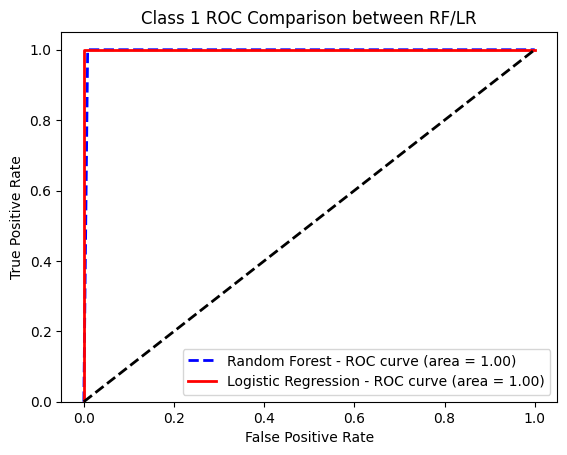

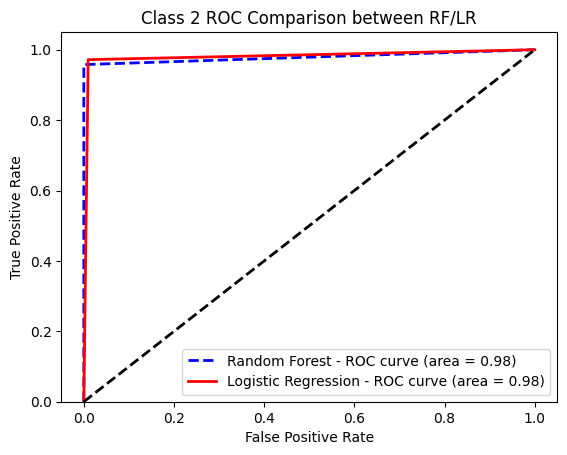

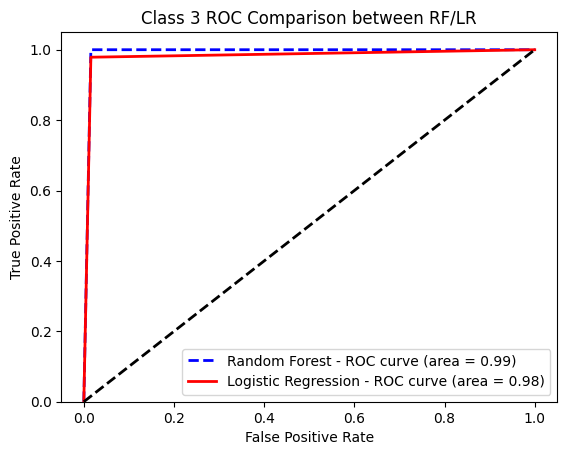

In [52]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_bin = label_binarize(y, classes=[1, 2, 3])
y_pred_model1 = label_binarize(rf_pred, classes=[1, 2, 3])
y_pred_model2 = label_binarize(lr_pred, classes=[1, 2, 3])

n_classes = y_bin.shape[1]

# Compute ROC curve and ROC area for each class for both models
fpr = dict()
tpr = dict()
roc_auc = dict()

# Model 1
for i in range(n_classes):
    fpr["Random Forest", i], tpr["Random Forest", i], _ = roc_curve(y_bin[:, i], y_pred_model1[:, i])
    roc_auc["Random Forest", i] = auc(fpr["Random Forest", i], tpr["Random Forest", i])

# Model 2
for i in range(n_classes):
    fpr["Logistic Regression", i], tpr["Logistic Regression", i], _ = roc_curve(y_bin[:, i], y_pred_model2[:, i])
    roc_auc["Logistic Regression", i] = auc(fpr["Logistic Regression", i], tpr["Logistic Regression", i])

# Plotting
for i in range(n_classes):
    plt.figure(i)
    plt.plot(fpr["Random Forest", i], tpr["Random Forest", i], color='blue', lw=2, linestyle='--',
             label='Random Forest - ROC curve (area = {0:0.2f})'.format(roc_auc["Random Forest", i]))
    plt.plot(fpr["Logistic Regression", i], tpr["Logistic Regression", i], color='red', lw=2,
             label='Logistic Regression - ROC curve (area = {0:0.2f})'.format(roc_auc["Logistic Regression", i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {i+1} ROC Comparison between RF/LR')
    plt.legend(loc="lower right")

plt.show()
